In [587]:
import torch 
import torch.nn 
import torch.nn.functional as F 
import torch.optim as optim 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torchvision 
from torchvision import datasets

In [588]:
import os 
video_dir = "C:/Users/araya/Desktop/vscode/Deep-Learning-Coding/MediaPipe/Data for Different actions"
video_list = []
video_list = os.listdir(video_dir)

print(len(video_list))
print(video_list)

160
['กฎกระทรวง.mp4', 'กฎกระทรวง_0.mp4', 'กฎกระทรวง_1.mp4', 'กฎกระทรวง_2.mp4', 'กฎหมายรัฐธรรมนูญ.mp4', 'กฎหมายรัฐธรรมนูญ_0.mp4', 'กฎหมายรัฐธรรมนูญ_1.mp4', 'กฎหมายรัฐธรรมนูญ_2.mp4', 'กรมอนามัย.mp4', 'กรมอนามัย_0.mp4', 'กรมอนามัย_1.mp4', 'กรมอนามัย_2.mp4', 'กรรม.mp4', 'กรรม_0.mp4', 'กรรม_1.mp4', 'กรรม_2.mp4', 'กรรมสิทธิ์.mp4', 'กรรมสิทธิ์_0.mp4', 'กรรมสิทธิ์_1.mp4', 'กรรมสิทธิ์_2.mp4', 'กระโดด.mp4', 'กระโดด_0.mp4', 'กระโดด_1.mp4', 'กระโดด_2.mp4', 'กล้วยบวชชี.mp4', 'กล้วยบวชชี_0.mp4', 'กล้วยบวชชี_1.mp4', 'กล้วยบวชชี_2.mp4', 'กล้วยเชื่อม.mp4', 'กล้วยเชื่อม_0.mp4', 'กล้วยเชื่อม_1.mp4', 'กล้วยเชื่อม_2.mp4', 'กังวล.mp4', 'กังวล_0.mp4', 'กังวล_1.mp4', 'กังวล_2.mp4', 'กีฬา.mp4', 'กีฬา_0.mp4', 'กีฬา_1.mp4', 'กีฬา_2.mp4', 'น้อง.mp4', 'น้อง_0.mp4', 'น้อง_1.mp4', 'น้อง_2.mp4', 'เขิน.mp4', 'เขิน_0.mp4', 'เขิน_1.mp4', 'เขิน_2.mp4', 'เขื่อนดิน.mp4', 'เขื่อนดิน_0.mp4', 'เขื่อนดิน_1.mp4', 'เขื่อนดิน_2.mp4', 'เขื่อนสิริกิติ์.mp4', 'เขื่อนสิริกิติ์_0.mp4', 'เขื่อนสิริกิติ์_1.mp4', 'เขื่อนสิริกิติ์_2.mp4',

In [589]:
actions = np.array(video_list)
print(actions)

['กฎกระทรวง.mp4' 'กฎกระทรวง_0.mp4' 'กฎกระทรวง_1.mp4' 'กฎกระทรวง_2.mp4'
 'กฎหมายรัฐธรรมนูญ.mp4' 'กฎหมายรัฐธรรมนูญ_0.mp4' 'กฎหมายรัฐธรรมนูญ_1.mp4'
 'กฎหมายรัฐธรรมนูญ_2.mp4' 'กรมอนามัย.mp4' 'กรมอนามัย_0.mp4'
 'กรมอนามัย_1.mp4' 'กรมอนามัย_2.mp4' 'กรรม.mp4' 'กรรม_0.mp4' 'กรรม_1.mp4'
 'กรรม_2.mp4' 'กรรมสิทธิ์.mp4' 'กรรมสิทธิ์_0.mp4' 'กรรมสิทธิ์_1.mp4'
 'กรรมสิทธิ์_2.mp4' 'กระโดด.mp4' 'กระโดด_0.mp4' 'กระโดด_1.mp4'
 'กระโดด_2.mp4' 'กล้วยบวชชี.mp4' 'กล้วยบวชชี_0.mp4' 'กล้วยบวชชี_1.mp4'
 'กล้วยบวชชี_2.mp4' 'กล้วยเชื่อม.mp4' 'กล้วยเชื่อม_0.mp4'
 'กล้วยเชื่อม_1.mp4' 'กล้วยเชื่อม_2.mp4' 'กังวล.mp4' 'กังวล_0.mp4'
 'กังวล_1.mp4' 'กังวล_2.mp4' 'กีฬา.mp4' 'กีฬา_0.mp4' 'กีฬา_1.mp4'
 'กีฬา_2.mp4' 'น้อง.mp4' 'น้อง_0.mp4' 'น้อง_1.mp4' 'น้อง_2.mp4' 'เขิน.mp4'
 'เขิน_0.mp4' 'เขิน_1.mp4' 'เขิน_2.mp4' 'เขื่อนดิน.mp4' 'เขื่อนดิน_0.mp4'
 'เขื่อนดิน_1.mp4' 'เขื่อนดิน_2.mp4' 'เขื่อนสิริกิติ์.mp4'
 'เขื่อนสิริกิติ์_0.mp4' 'เขื่อนสิริกิติ์_1.mp4' 'เขื่อนสิริกิติ์_2.mp4'
 'เข้าใจผิด.mp4' 'เข้าใจผิด_0.mp4' 'เข้าใจผิด_

In [590]:
file_paths = []
for action in actions:
    video_path = os.path.join('Data for different actions/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎกระทรวง_0.mp4/กฎกระทรวง_0.npy', 'Data for different actions/กฎกระทรวง_1.mp4/กฎกระทรวง_1.npy', 'Data for different actions/กฎกระทรวง_2.mp4/กฎกระทรวง_2.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ_0.mp4/กฎหมายรัฐธรรมนูญ_0.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ_1.mp4/กฎหมายรัฐธรรมนูญ_1.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ_2.mp4/กฎหมายรัฐธรรมนูญ_2.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรมอนามัย_0.mp4/กรมอนามัย_0.npy', 'Data for different actions/กรมอนามัย_1.mp4/กรมอนามัย_1.npy', 'Data for different actions/กรมอนามัย_2.mp4/กรมอนามัย_2.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรม_0.mp4/กรรม_0.npy', 'Data for different actions/กรรม_1.mp4/กรรม_1.npy', 'Data for different actions/กรรม_2.mp4/กรรม_2.npy', 'Data f

In [591]:
import pandas as pd
df = pd.read_csv("script1.csv")

In [592]:
labels = []

for i in range(len(df.label)):
    labels.append(df.label[i])

In [593]:
print(labels)

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39]


### Create Dataset

In [594]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Create a custom dataset
class KeypointDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        keypoints = np.load(self.file_paths[idx])
        label = self.labels[idx]
        return torch.tensor(keypoints, dtype=torch.float32), label

In [595]:
dataset = KeypointDataset(file_paths, labels)

In [596]:
print(dataset.file_paths[127])
print(dataset.labels[127])

Data for different actions/เฮโรอีน_2.mp4/เฮโรอีน_2.npy
31


### Spilt to train dataset, validate dataset, test dataset

In [597]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [128,16,16]) # Spilt to 0.8 : 0.1 : 0.1

In [598]:
# Collate function for padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, torch.tensor(labels)

In [599]:
# Create the DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

In [600]:
for i, (data, label) in enumerate(train_loader):
    print(data)
    print(label)
    break

tensor([[[0.6521, 0.1974, 0.7217,  ..., 0.1829, 0.7728, 0.1819],
         [0.6531, 0.1975, 0.7221,  ..., 0.1821, 0.7723, 0.1811],
         [0.6537, 0.1979, 0.7221,  ..., 0.1828, 0.7731, 0.1818],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4945, 0.2362, 0.5214,  ..., 0.2115, 0.5529, 0.2086],
         [0.4947, 0.2363, 0.5218,  ..., 0.2122, 0.5528, 0.2094],
         [0.4951, 0.2364, 0.5225,  ..., 0.2128, 0.5531, 0.2099],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4868, 0.2821, 0.5248,  ..., 0.2365, 0.5711, 0.2335],
         [0.4861, 0.2786, 0.5238,  ..., 0.2362, 0.5702, 0.2334],
         [0.4856, 0.2769, 0.5231,  ..., 0.2361, 0.5699, 0.

In [601]:
print(data[11][12])

tensor([0.5264, 0.3853, 0.5451,  ..., 0.3748, 0.5625, 0.3741])


### Recheck by loading between Numpy-Array and Dataloader

In [602]:
data[11][12]

tensor([0.5264, 0.3853, 0.5451,  ..., 0.3748, 0.5625, 0.3741])

In [603]:
label[1] # กรมอนามัย

tensor(21)

In [604]:
np.load("Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy")[12]

array([0.50309116, 0.23802432, 0.5351935 , ..., 0.21127783, 0.56641209,
       0.20872808])

### ---------------------------------------------------------------------------------------------------------------------------------------

### Model

In [605]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [606]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output: (batch_size, sequence_length, hidden_size)
        attention_scores = self.attention_weights(lstm_output)  # (batch_size, sequence_length, 1)
        attention_weights = torch.softmax(attention_scores, dim=1)  # (batch_size, sequence_length, 1)
        weighted_output = torch.sum(lstm_output * attention_weights, dim=1)  # (batch_size, hidden_size)
        return weighted_output, attention_weights

In [607]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,dropout):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.pool = nn.MaxPool2d(kernel_size=(2,1), stride=1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = AttentionLayer(hidden_size)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, h, c):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Apply pooling before LSTM
        # x = self.pool(x)

        # Forward propagate the LSTM
        lstm_output, (h,c) = self.lstm(x, (h,c))

        # Apply attention to the LSTM output
        attention_output, attention_weights = self.attention(lstm_output)

        # Classification based on attention output
        out = F.relu(self.fc1(attention_output))
        out = self.dropout(out)
        out = self.fc2(out)
        return out, h, c

In [608]:
input_size = 1086
hidden_size = 256 
num_layers = 2
num_classes = 40

In [609]:
model = LSTMModel(input_size=1086, hidden_size=256, num_layers=2, num_classes=40, dropout=0.1).to(device)

In [610]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification 
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [611]:
from sklearn.metrics import f1_score, recall_score

num_epochs = 500
loss_logger = []
accuracy_logger = []
f1_logger = []
recall_logger = []
running_loss = 0.0 
val_loss = []

all_preds = []
all_labels = []
for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0

    h = torch.zeros(num_layers, batch_size, hidden_size).to(device)
    c = torch.zeros(num_layers, batch_size, hidden_size).to(device)
    
    all_preds = []
    all_labels = []

    for i, (sequences, labels) in enumerate(train_loader):
        sequences = sequences.to(device)
        labels = labels.to(device)

        h = h.detach()
        c = c.detach()
        
        # Forward pass
        outputs, h, c = model(sequences, h, c)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())    # Store true labels
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Log training loss and accuracy
    loss_logger.append(loss.item())
    accuracy = 100 * total_correct / total_samples
    accuracy_logger.append(accuracy)

    # Calculate F1 score and recall for training set
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1_logger.append(f1)
    recall_logger.append(recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.2f}, Recall: {recall:.2f}')

    # --- Validation Loop ---
    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_samples = 0
    val_preds = []
    val_labels = []
    running_val_loss = 0.0  # Reset running loss for validation

    with torch.no_grad():  # Disable gradient calculation for validation
        h_val = torch.zeros(num_layers, batch_size, hidden_size).to(device)
        c_val = torch.zeros(num_layers, batch_size, hidden_size).to(device)

        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs, h_val, c_val = model(sequences, h_val, c_val)
            loss = criterion(outputs, labels) 
            running_val_loss += loss.item() 

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_samples += labels.size(0)

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader)  # Average validation loss
        val_loss.append(avg_val_loss)  # Log validation loss

        val_accuracy = 100 * val_correct / val_samples
        val_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=1 )
        val_recall = recall_score(val_labels, val_preds, average='weighted', zero_division=1)

        print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, F1 Score: {val_f1:.2f}, Recall: {val_recall:.2f}')

# --- Test Loop (after all epochs) ---
model.eval()  # Set model to evaluation mode for testing
test_correct = 0
test_samples = 0
test_preds = []
test_labels = []

with torch.no_grad():  # Disable gradient calculation for testing
    h_test = torch.zeros(num_layers, batch_size, hidden_size).to(device)
    c_test = torch.zeros(num_layers, batch_size, hidden_size).to(device)

    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, h_test, c_test = model(sequences, h_test, c_test)
        _, predicted = torch.max(outputs, 1)

        test_correct += (predicted == labels).sum().item()
        test_samples += labels.size(0)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * test_correct / test_samples
    test_f1 = f1_score(test_labels, test_preds, average='weighted', zero_division=1 )
    test_recall = recall_score(test_labels, test_preds, average='weighted', zero_division=1)

    print(f'Test Accuracy: {test_accuracy:.2f}%, F1 Score: {test_f1:.2f}, Recall: {test_recall:.2f}')


Epoch [1/500], Loss: 3.6952, Accuracy: 0.78%, F1 Score: 0.00, Recall: 0.01
Validation Loss: 3.6863, Accuracy: 6.25%, F1 Score: 0.01, Recall: 0.06
Epoch [2/500], Loss: 3.6969, Accuracy: 2.34%, F1 Score: 0.00, Recall: 0.02
Validation Loss: 3.6879, Accuracy: 6.25%, F1 Score: 0.01, Recall: 0.06
Epoch [3/500], Loss: 3.6780, Accuracy: 1.56%, F1 Score: 0.00, Recall: 0.02
Validation Loss: 3.6911, Accuracy: 6.25%, F1 Score: 0.01, Recall: 0.06
Epoch [4/500], Loss: 3.6758, Accuracy: 3.12%, F1 Score: 0.00, Recall: 0.03
Validation Loss: 3.6957, Accuracy: 6.25%, F1 Score: 0.01, Recall: 0.06
Epoch [5/500], Loss: 3.6708, Accuracy: 3.12%, F1 Score: 0.00, Recall: 0.03
Validation Loss: 3.7025, Accuracy: 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [6/500], Loss: 3.6406, Accuracy: 3.91%, F1 Score: 0.02, Recall: 0.04
Validation Loss: 3.7098, Accuracy: 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [7/500], Loss: 3.6784, Accuracy: 3.91%, F1 Score: 0.02, Recall: 0.04
Validation Loss: 3.7219, Accuracy: 0.00%, F1 Scor

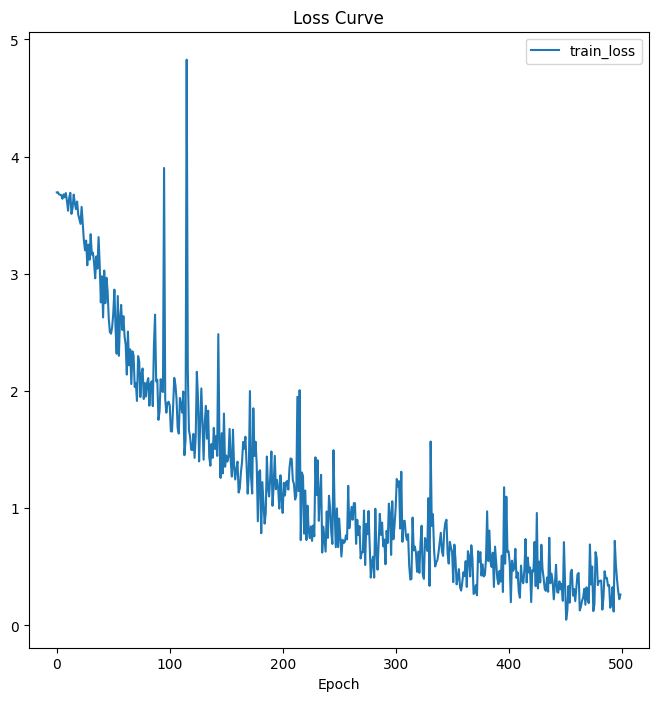

In [612]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Loss Curve")
plt.plot(loss_logger, label='train_loss')
# plt.plot(val_loss, label='val_loss')
# plt.plot(accuracy_logger,label='accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

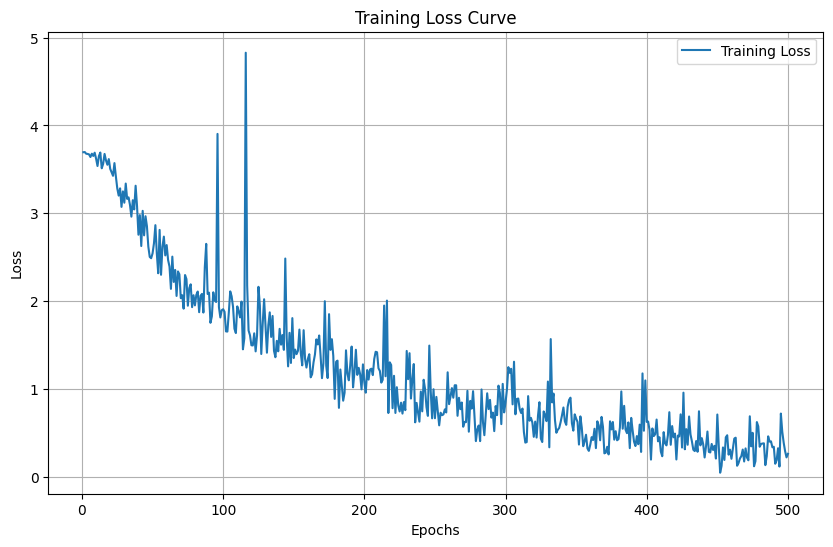

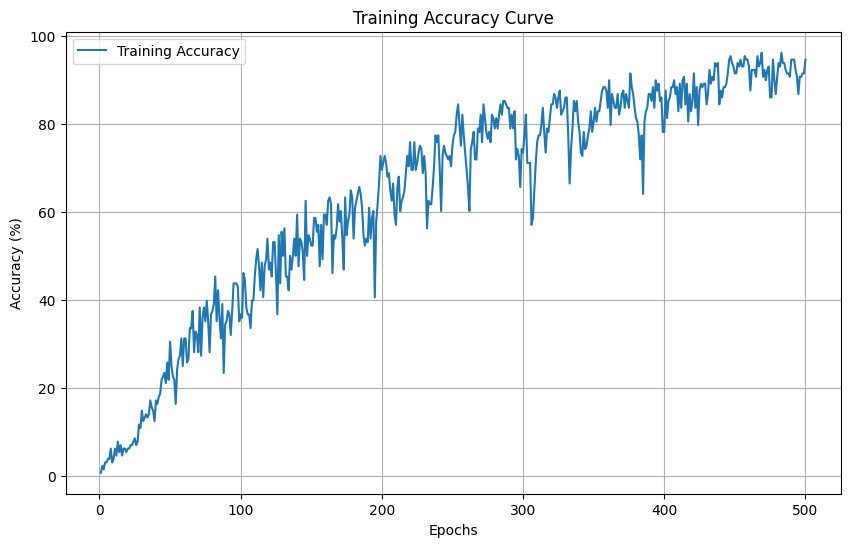

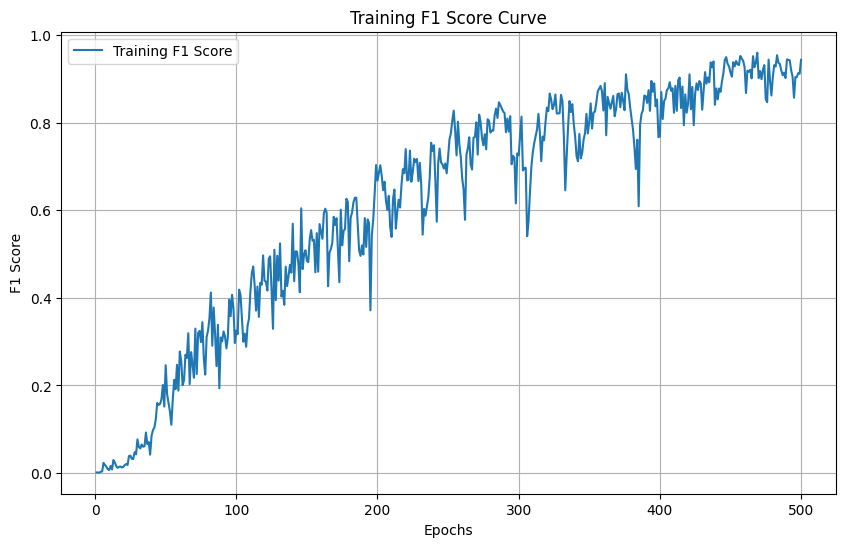

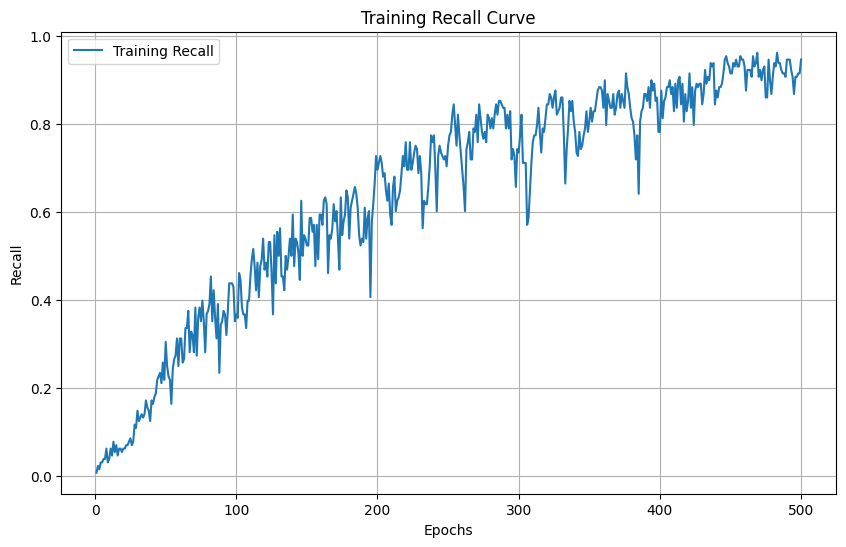

In [613]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_logger, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), accuracy_logger, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot the F1 score curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), f1_logger, label='Training F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training F1 Score Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot the recall curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), recall_logger, label='Training Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [614]:
def check_accuracy(loader, model, h, c):
    if loader == train_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")  
          
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            # x = x.reshape(x.shape[0], -1)
            
            scores,h,c = model(x,h,c)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
        
    model.train()

In [615]:
check_accuracy(train_loader, model,h,c)
check_accuracy(test_loader, model,h,c)

Checking accuracy on training data
Got 121 / 128 with accuracy 94.53
Checking accuracy on test data
Got 6 / 16 with accuracy 37.50


### Save Model

In [616]:
# torch.save(model.state_dict(), 'saved_data/attention_lstm.pt')
# torch.save(optimizer.state_dict(), 'saved_data/optimizer.pt')
# # torch.save(scheduler.state_dict(), 'saved_data/scheduler.pt')